In [4]:
import sys
print(sys.executable)

/home/sc.uni-leipzig.de/da22digu/.conda/envs/kamay_kndvi_baseline_submission/bin/python


In [ ]:
#from load import load_store_kndvi
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import matplotlib.dates as mdates
#distributed computing
import dask.dataframe as dd
import dask
from dask import delayed, compute
from joblib import Parallel, delayed
from tqdm import tqdm
## minimal regression test
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
#loading train
try:
    # Works in regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Fallback for Jupyter or interactive environments
    current_dir = os.getcwd()
# Go up one level
project_root = os.path.dirname(current_dir)
# Results folder path
path = os.path.join(project_root, "results")
# Paths to original data
path_train = "/work/gk62kagy-kndvi_prediction_challenge_data/train.npz"
path_val   = "/work/gk62kagy-kndvi_prediction_challenge_data/validation.npz"
path_test  = "/work/gk62kagy-kndvi_prediction_challenge_data/test_nosolution.npz"
def load_store_kndvi(path_results: str = path, path_train:str=path_train, 
                     path_val:str=path_val, path_test:str=path_test, 
                     test:bool=False, 
                     train: bool = False, 
                     val: bool = False) -> None:
    """Loads only the kNDVI variable (index 4) from a .npz dataset and saves it separately."""
    kndvi_index = 4  # Confirmed from variable order in documentation

    if train:
        with np.load(path_train) as data:
            kndvi_train = data['train'][:, :, kndvi_index]
            np.savez_compressed(os.path.join(path_results, "train_kndvi.npz"), kndvi=kndvi_train)

    if val:
        with np.load(path_val) as data:
            kndvi_val = data['validation'][:, :, kndvi_index]
            np.savez_compressed(os.path.join(path_results, "val_kndvi.npz"), kndvi=kndvi_val)
    if test:
        with np.load(path_test) as data:
            kndvi_test = data['test'][:, :, kndvi_index]
            np.savez_compressed(os.path.join(path_results, "test_nosolution.npz"), kndvi=kndvi_test)
load_store_kndvi()   
logging.info(f"Results folder path:, {path}")
path_train = os.path.join(path, "train_kndvi.npz")
path_val=  os.path.join(path, "val_kndvi.npz")
path_test = os.path.join(path, "test_nosolution.npz")
train_kndvi = np.load(path_train)
val_kndvi= np.load(path_val)
test_kndvi = np.load(path_test)

In [7]:
train_kndvi = train_kndvi['kndvi'].astype(np.float32)
val_kndvi   = val_kndvi['kndvi'].astype(np.float32)
test_kndvi  = test_kndvi['kndvi'].astype(np.float32)

In [8]:
# Flatten and remove NaNs (should be none in train/val)
train_vals = train_kndvi.flatten()
val_vals = val_kndvi.flatten()

# Compute summary statistics
def compute_summary(values):
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values),
        "std": np.std(values),
        "var": np.var(values),
        "p01": np.percentile(values, 1),
        "p25": np.percentile(values, 25),
        "p75": np.percentile(values, 75),
        "p99": np.percentile(values, 99),
    }

summary_train = compute_summary(train_vals)
summary_val = compute_summary(val_vals)

# Combine into DataFrame
summary_df = pd.DataFrame({
    "Train kNDVI": summary_train,
    "Validation kNDVI": summary_val
})

In [9]:
summary_df

,Train kNDVI,Validation kNDVI
min,-334.869995,-2.510983
max,162.689270,2.873523
mean,0.127536,0.109977
median,0.010049,0.012530
std,0.410164,0.170848
var,0.168235,0.029189
p01,0.000276,0.000222
p25,0.002205,0.002695
p75,0.214714,0.154878
p99,0.625707,0.601978


## Basics shapes & NaN counts

In [10]:
print("Train:", train_kndvi.shape)
print("Validation:", val_kndvi.shape)
print("Test:", test_kndvi.shape)

# NaN stats
print("Train NaNs:", np.isnan(train_kndvi).sum())
print("Validation NaNs:", np.isnan(val_kndvi).sum())
print("Test NaNs (last 92 time steps):", np.isnan(test_kndvi[:, -92:]).sum())
print("Test NaNs (total):", np.isnan(test_kndvi).sum())


Train: (214751, 1004)
Validation: (71755, 1004)
Test: (67548, 1004)
Train NaNs: 0
Validation NaNs: 0
Test NaNs (last 92 time steps): 6214416
Test NaNs (total): 6214416


- Long historical, consistent train data
- From 2000 to 2020, we have 1004 time steps, and it is aligned across all datasets
- Validation data is just a small fraction of the dataset
- Real values to test the predictions are smaller than the validation dataset
- We need to explore the meaning of the NaNs in Test

**NaNs in test dataset**
- The last 92 time steps (from mid-2019 onward) are masked in all test pixels
- These are targets to be predicted


## Global mean kNDVI time series

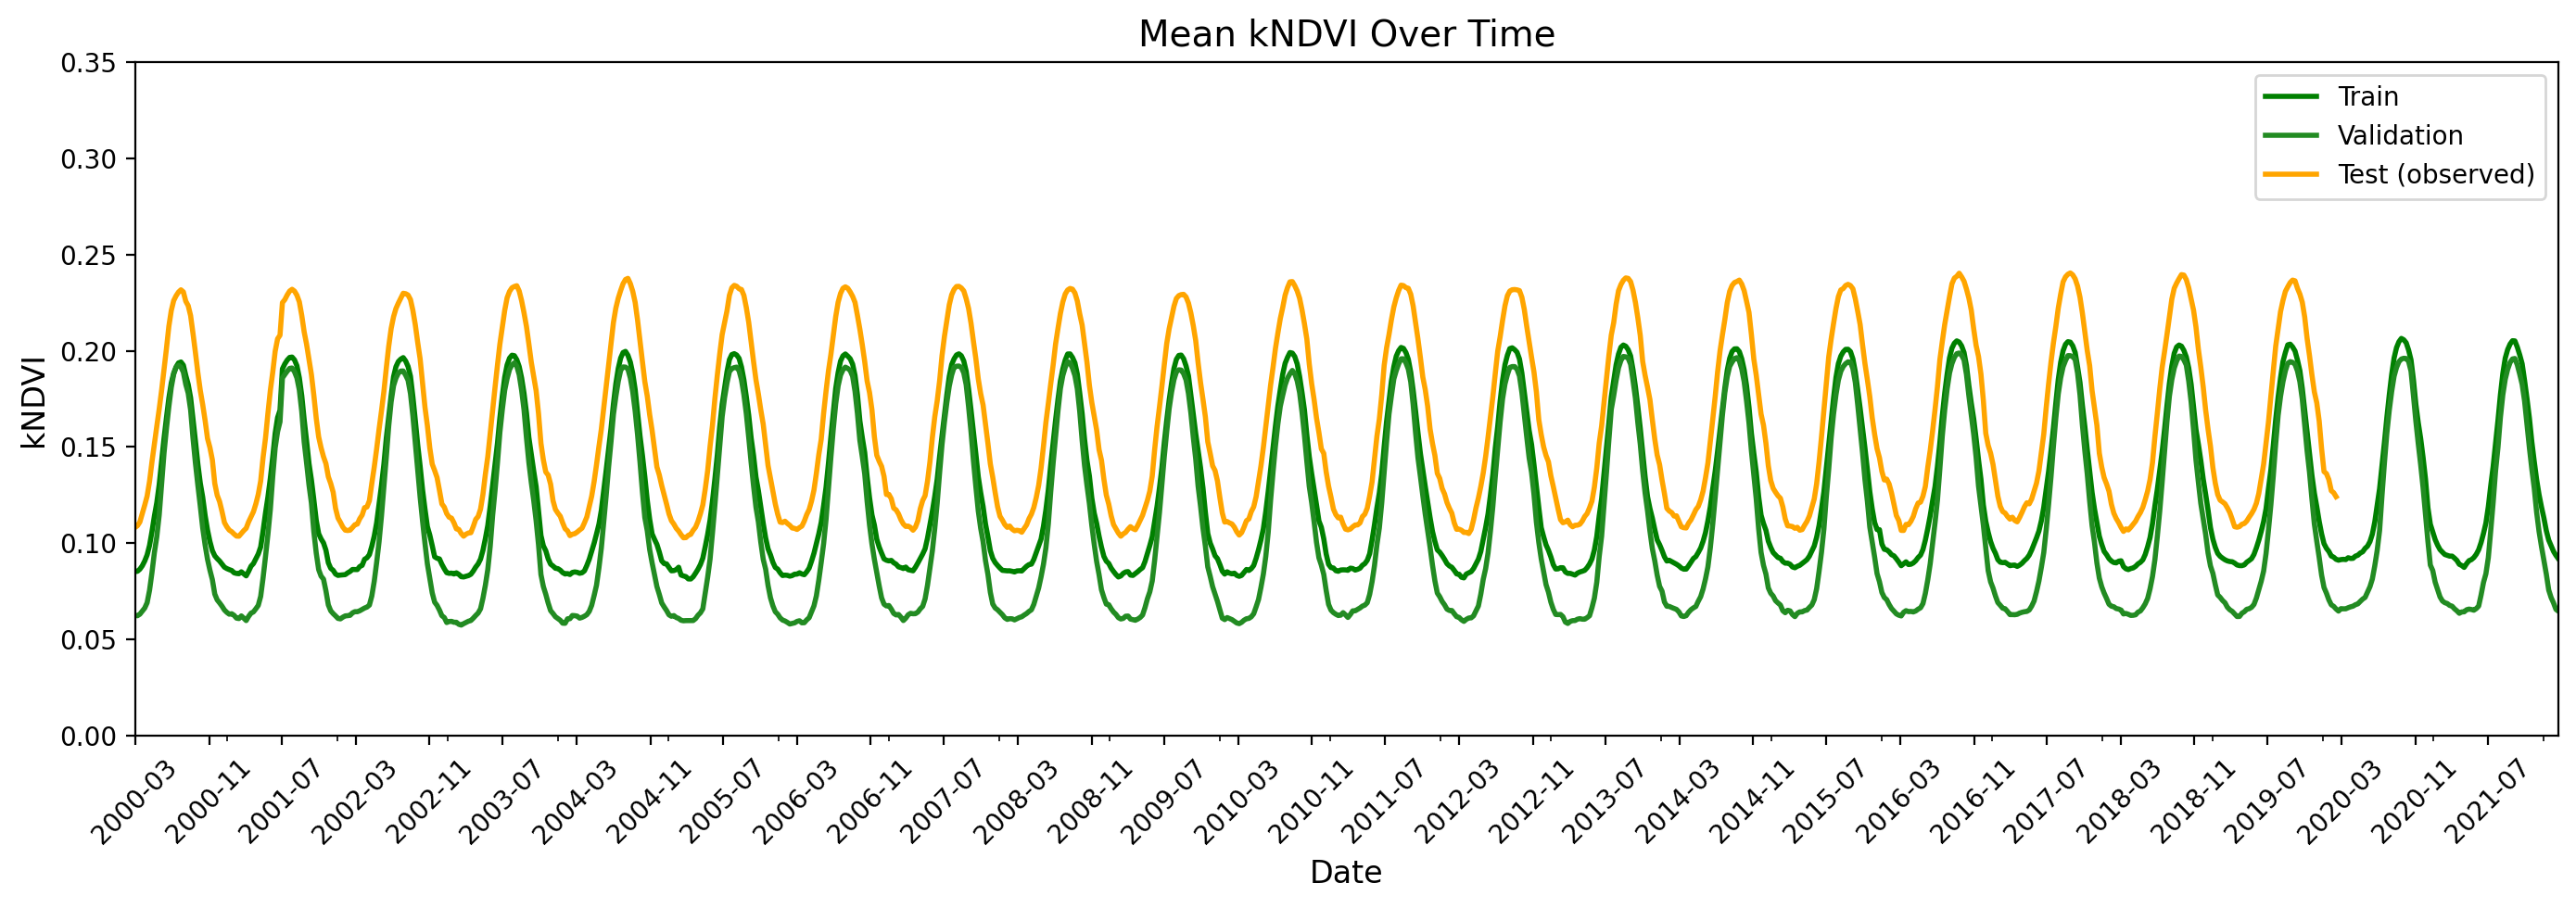

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define time indices
full_time_index = pd.date_range("2000-03-01", periods=1004, freq="8D")
test_time_index = pd.date_range("2000-03-01", periods=912, freq="8D")

# Plotting function
def plot_mean_kndvi(data, label, color, time_idx):
    mean_series = np.nanmean(data, axis=0)
    pd.Series(mean_series, index=time_idx).plot(label=label, color=color, linewidth=2)

# Plot
plt.figure(figsize=(14, 5), dpi=200)

plot_mean_kndvi(train_kndvi, "Train", "green", full_time_index)
plot_mean_kndvi(val_kndvi, "Validation", "forestgreen", full_time_index)
plot_mean_kndvi(test_kndvi[:, :-92], "Test (observed)", "orange", test_time_index)

# Axis labels and formatting
plt.title("Mean kNDVI Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("kNDVI", fontsize=12)
plt.ylim(0, 0.35)
plt.xticks(rotation=45)

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))

#plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"{path}/figures/timeseries.png")
plt.show()



1. Seasonal and consistent pattern in kNDVI across all datasets
    - the green (train), blue (validation), and orange (test) lines all show strong seasonal oscillations with an annual frequency
    - peaks and troughs occur roughly at the same time every year; consistent phenological cycles (vegetation growth/senescence)
    - this validates the temporal alignment and quality of the data.
  
2. It confirms the missing NaNs pixels masked (set to NaN) after 2020 (orange line)
    - there are no visible distortions, indicating clean masking 
      
3. Train data (green line) has more higher mean values than validation (blue line)
    - This suggests the train data includes regions with more vegetative cover, while validation might sample drier or degraded areas
    - Maybe the validation dataset was sampled in a way that introdces a spatial bias

*Hint: validation dataset is only a small part from the datacube*

## Temporal distribution by dataset

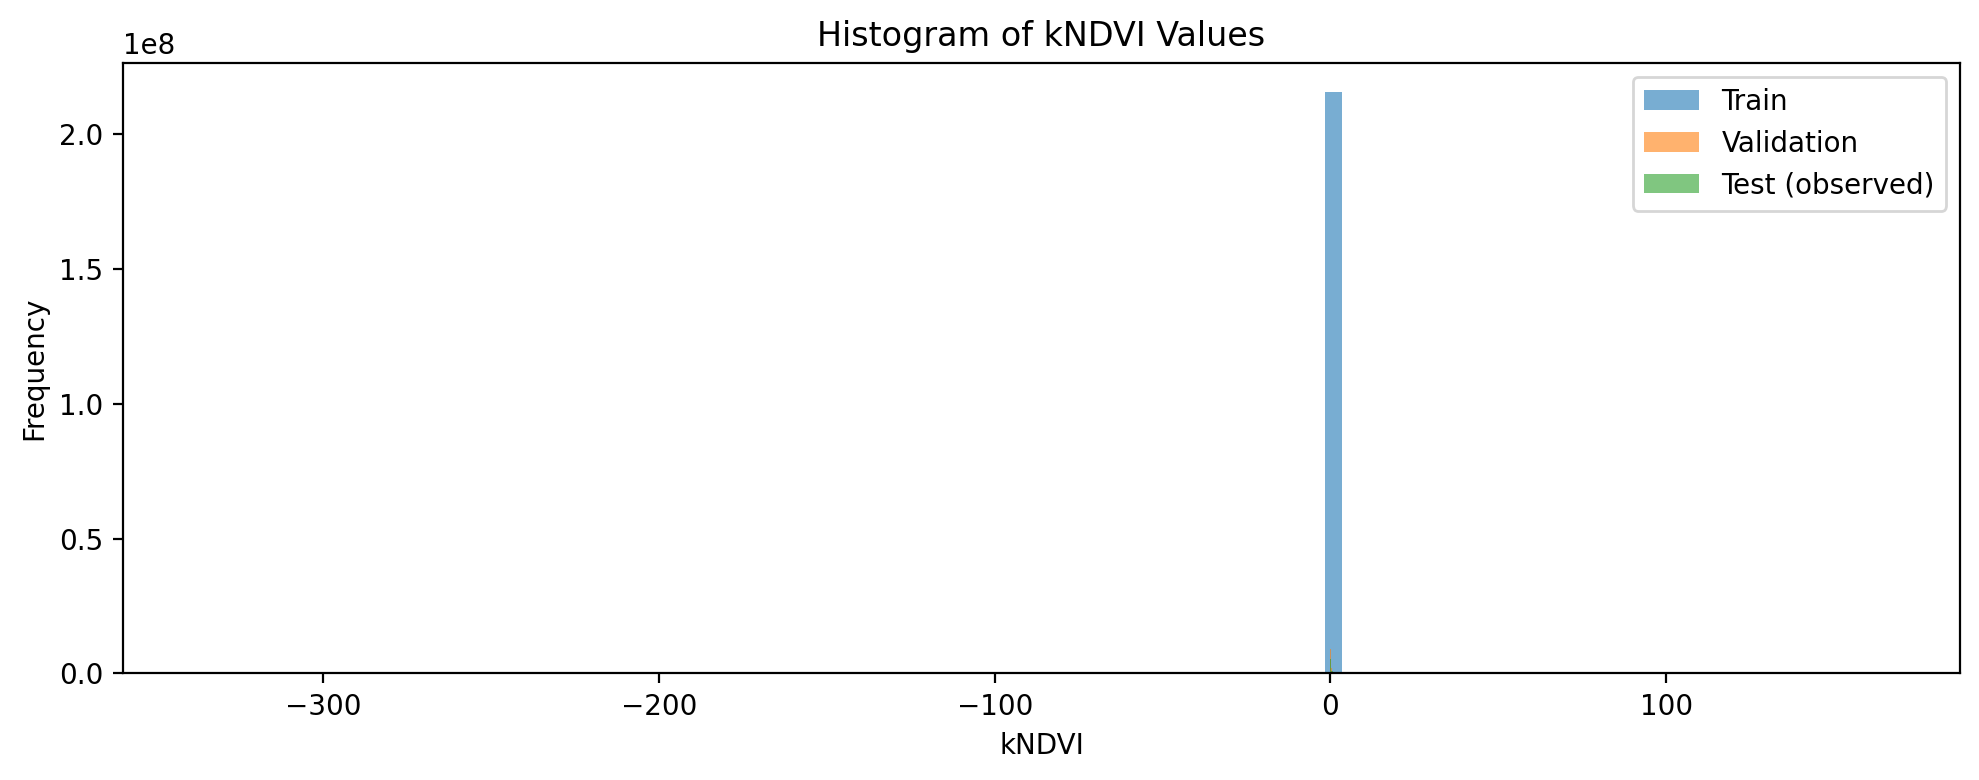

In [12]:
plt.figure(figsize=(10, 4), dpi=200)
plt.hist(train_kndvi.flatten(), bins=100, alpha=0.6, label="Train")
plt.hist(val_kndvi.flatten(), bins=100, alpha=0.6, label="Validation")
plt.hist(test_kndvi[:, :-92].flatten(), bins=100, alpha=0.6, label="Test (observed)")
plt.title("Histogram of kNDVI Values")
plt.xlabel("kNDVI")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


Same kNDVI values distribution across all datasets
- Most values are very close to 0
- The x-axis shows high values, which can imply the existence of potential outliers

In [13]:
# Flatten and filter
flat_train = train_kndvi.flatten()
flat_val = val_kndvi.flatten()
flat_test = test_kndvi[:, :-92].flatten()

# Define realistic NDVI bounds (float32 precision-safe)
valid_mask = lambda x: (x >= -1.0) & (x <= 1.0)

flat_train = flat_train[valid_mask(flat_train)]
flat_val   = flat_val[valid_mask(flat_val)]
flat_test  = flat_test[valid_mask(flat_test)]


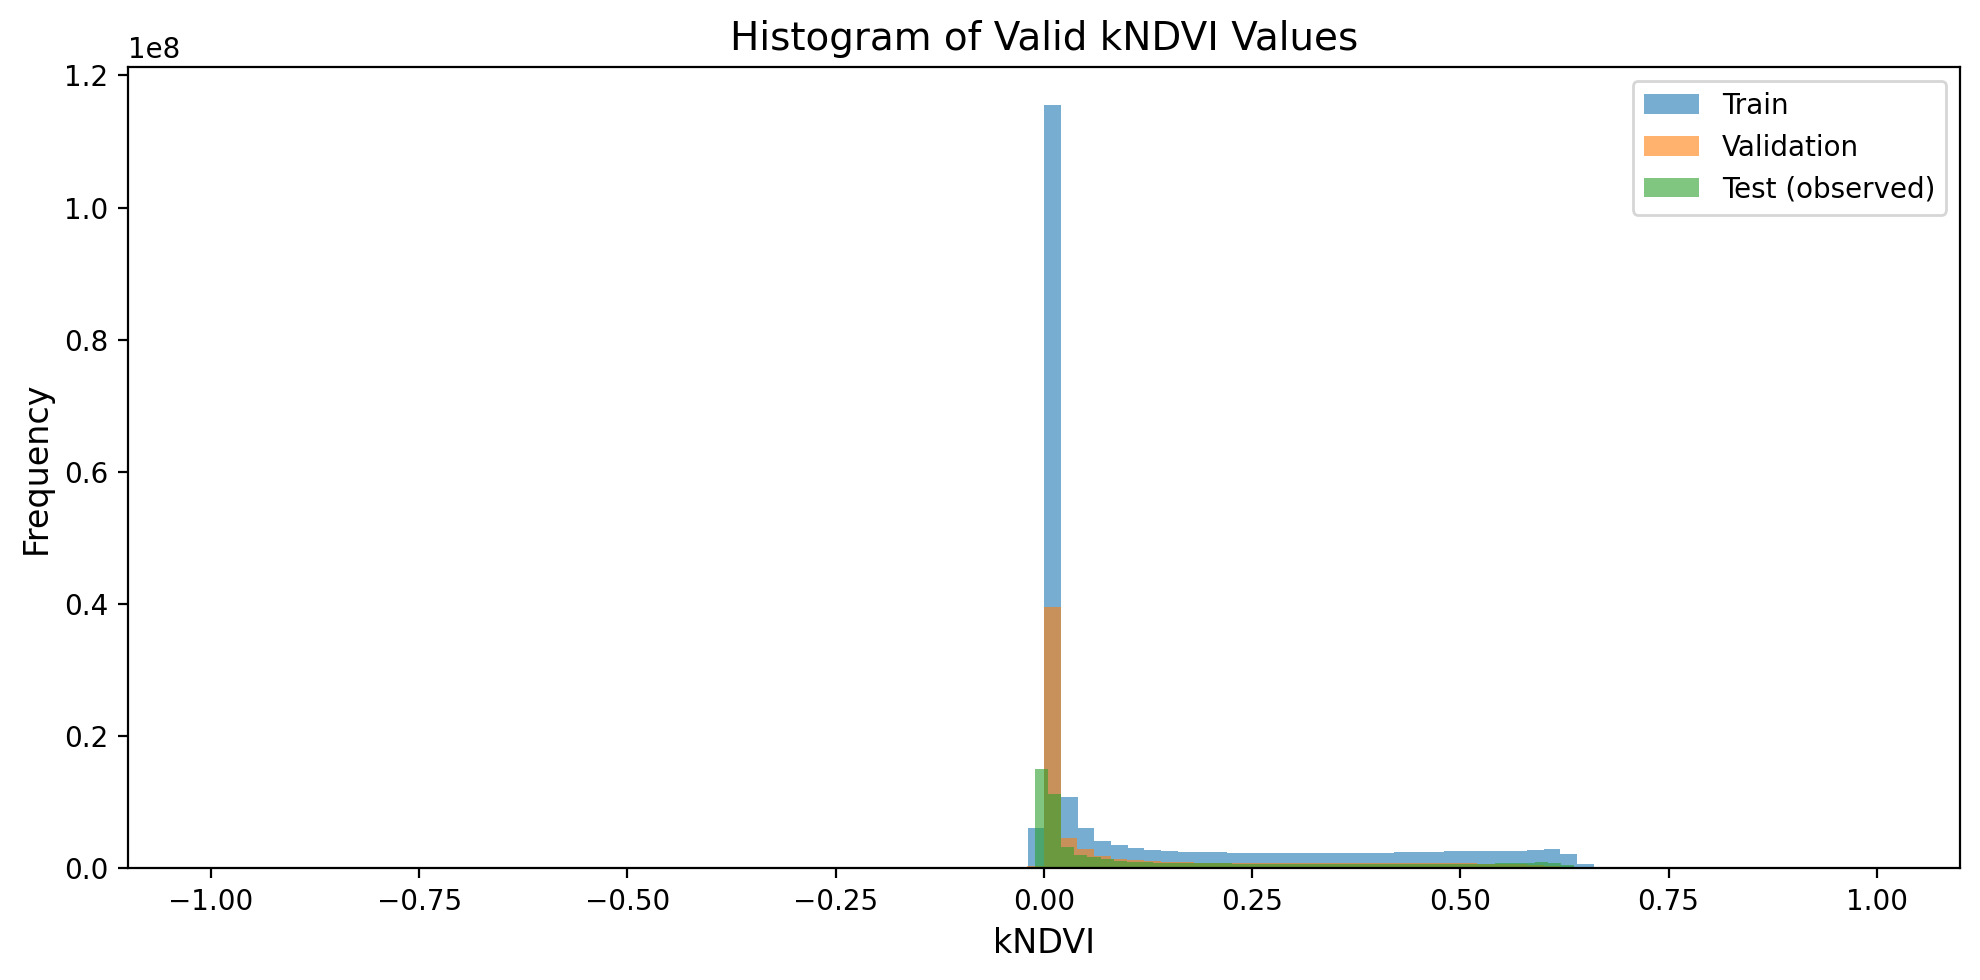

In [14]:

plt.figure(figsize=(10, 5), dpi=200)
plt.hist(flat_train, bins=100, alpha=0.6, label="Train")
plt.hist(flat_val, bins=100, alpha=0.6, label="Validation")
plt.hist(flat_test, bins=100, alpha=0.6, label="Test (observed)")
plt.title("Histogram of Valid kNDVI Values", fontsize=14)
plt.xlabel("kNDVI", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(f"{path}/figures/histogram.png")
plt.show()


Now it is possible to idenfity how differs slightly the differents datasets distribution.
- dominant peak near zero
- distribution similarity, despite of the long tails (blue dominance)
- conclusion, we can't scale with Global min-max across all pixels and time steps, because 99% of values are tightle packed near zero. This method would compress the rest of the distribution

## Missing data in test: sanity check

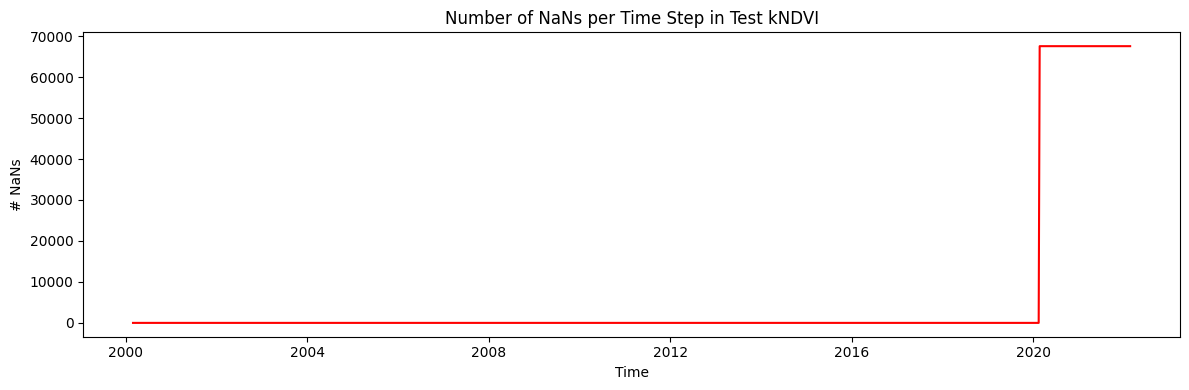

In [15]:
# Check if only last 92 time steps are NaN in test
mask = np.isnan(test_kndvi)
nan_per_time = mask.sum(axis=0)
time_index = pd.date_range("2000-03-01", periods=1004, freq="8D")

plt.figure(figsize=(12, 4))
plt.plot(time_index, nan_per_time, color="red")
plt.title("Number of NaNs per Time Step in Test kNDVI")
plt.xlabel("Time")
plt.ylabel("# NaNs")
plt.tight_layout()
plt.show()


It confirms the existence of null values after 2020

## Mean seasonal pattern (train)

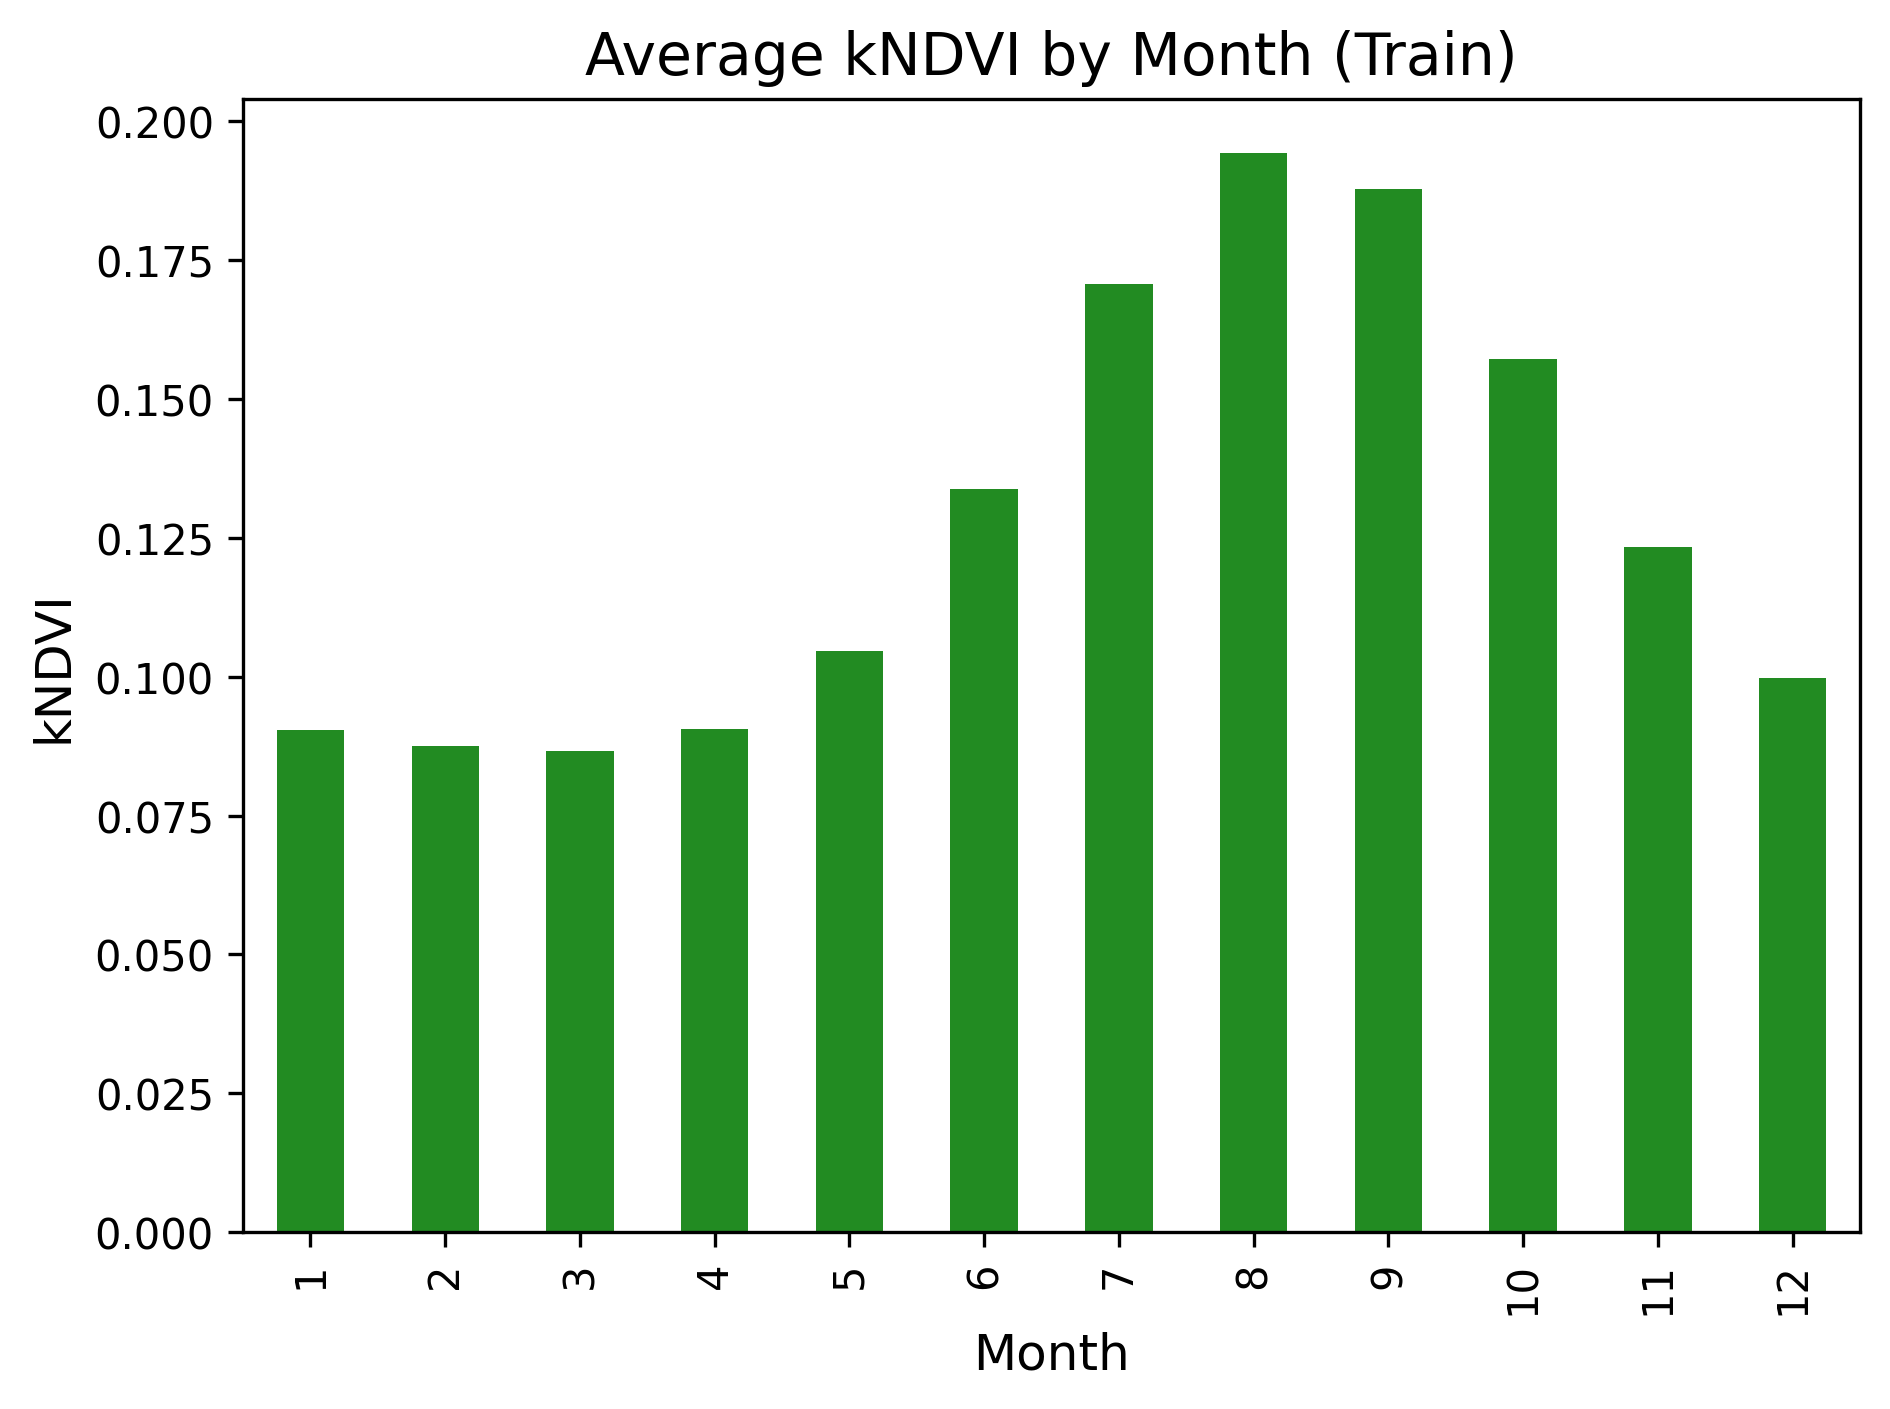

In [16]:
train_series = pd.DataFrame(train_kndvi.T, index=time_index)  # shape: (1004, n_samples)

# Group by month to get seasonality
monthly_mean = train_series.groupby(train_series.index.month).mean().mean(axis=1)

plt.figure(dpi=300)
monthly_mean.plot(kind='bar', color='forestgreen')
plt.title("Average kNDVI by Month (Train)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("kNDVI", fontsize=12)
plt.tight_layout()
plt.savefig(f"{path}/figures/avgkndvipermonth.png")
plt.show()


The graph reflects a strong seasonal cycle
- The plot shows the average kNDVI per calendar month over the entire train dataset (2000-2021), aggregated across all spatial points
- Growth phase, starts in month 4 (April) with a visible upward trend, and peaks in month 8 (August). This corresponds to spring and summer months in the Northern Hemisphere
- Senescense phase (September to March), declines from month 9 and reaches the lowest levels between December-March, corresponding to winder dormancy

In [17]:
print(train_kndvi.shape)
print(val_kndvi.shape)

(214751, 1004)
(71755, 1004)


# Implementing Ridge Regressor, Baseline

In [ ]:
def predict_pixel_ts(train_ts, val_ts, test_ts):
    """Fit model on train+val and predict last 92 steps of test."""
    try:
        # Create supervised features (lag 1)
        y_train = train_ts[1:]
        X_train = train_ts[:-1].reshape(-1, 1)

        y_val = val_ts[1:]
        X_val = val_ts[:-1].reshape(-1, 1)

        y_full = np.concatenate([y_train, y_val])
        X_full = np.concatenate([X_train, X_val])

        model = Ridge()
        model.fit(X_full, y_full)

        # Predict next 92 time steps using rolling
        y_preds = []
        last_val = val_ts[-1]
        for _ in range(92):
            next_input = np.array([[last_val]])
            next_val = model.predict(next_input)[0]
            y_preds.append(next_val)
            last_val = next_val  # feed it back

        return np.array(y_preds)
    except Exception as e:
        return np.full(92, np.nan)


In [ ]:
tasks = []
for i in range(1004):
    train_ts = train_kndvi[:, i]
    val_ts   = val_kndvi[:, i]
    test_ts  = test_kndvi[:, i]  # Only needed to check target shape

    task = delayed(predict_pixel_ts)(train_ts, val_ts, test_ts)
    tasks.append(task)

results = compute(*tasks, scheduler="threads")  # or use 'processes'


In [20]:
# shape: (1004, 92)
forecast_matrix = np.stack(results, axis=0)


In [21]:
# metrics
def compute_metrics(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)

    if mask.sum() == 0:
        return np.nan, np.nan, np.nan, np.nan

    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    mse = mean_squared_error(y_true_masked, y_pred_masked)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_masked - y_pred_masked) / (y_true_masked + 1e-8))) * 100
    mae = mean_absolute_error(y_true_masked, y_pred_masked)

    return mse, rmse, mape, mae

n_pixels = forecast_matrix.shape[0]
metrics = np.zeros((n_pixels, 4))  # columns: MSE, RMSE, MAPE, R2, MAE

y_true_all = test_kndvi[-92:, :].T  # shape (1004, 92)

for i in range(n_pixels):
    y_true = y_true_all[i]
    y_pred = forecast_matrix[i]
    metrics[i] = compute_metrics(y_true, y_pred)

mse_per_pixel  = metrics[:, 0]
rmse_per_pixel = metrics[:, 1]
mape_per_pixel = metrics[:, 2]
mae_per_pixel  = metrics[:, 3]

print("Mean MSE across all pixels:", np.nanmean(mse_per_pixel))
print("Mean RMSE across all pixels:", np.nanmean(rmse_per_pixel))
print("Mean absolute error across all pixels:", np.nanmean(mae_per_pixel))

Mean MSE across all pixels: 0.013046144657429275
Mean RMSE across all pixels: 0.10475983238738626
Mean absolute error across all pixels: 0.10307615169471032


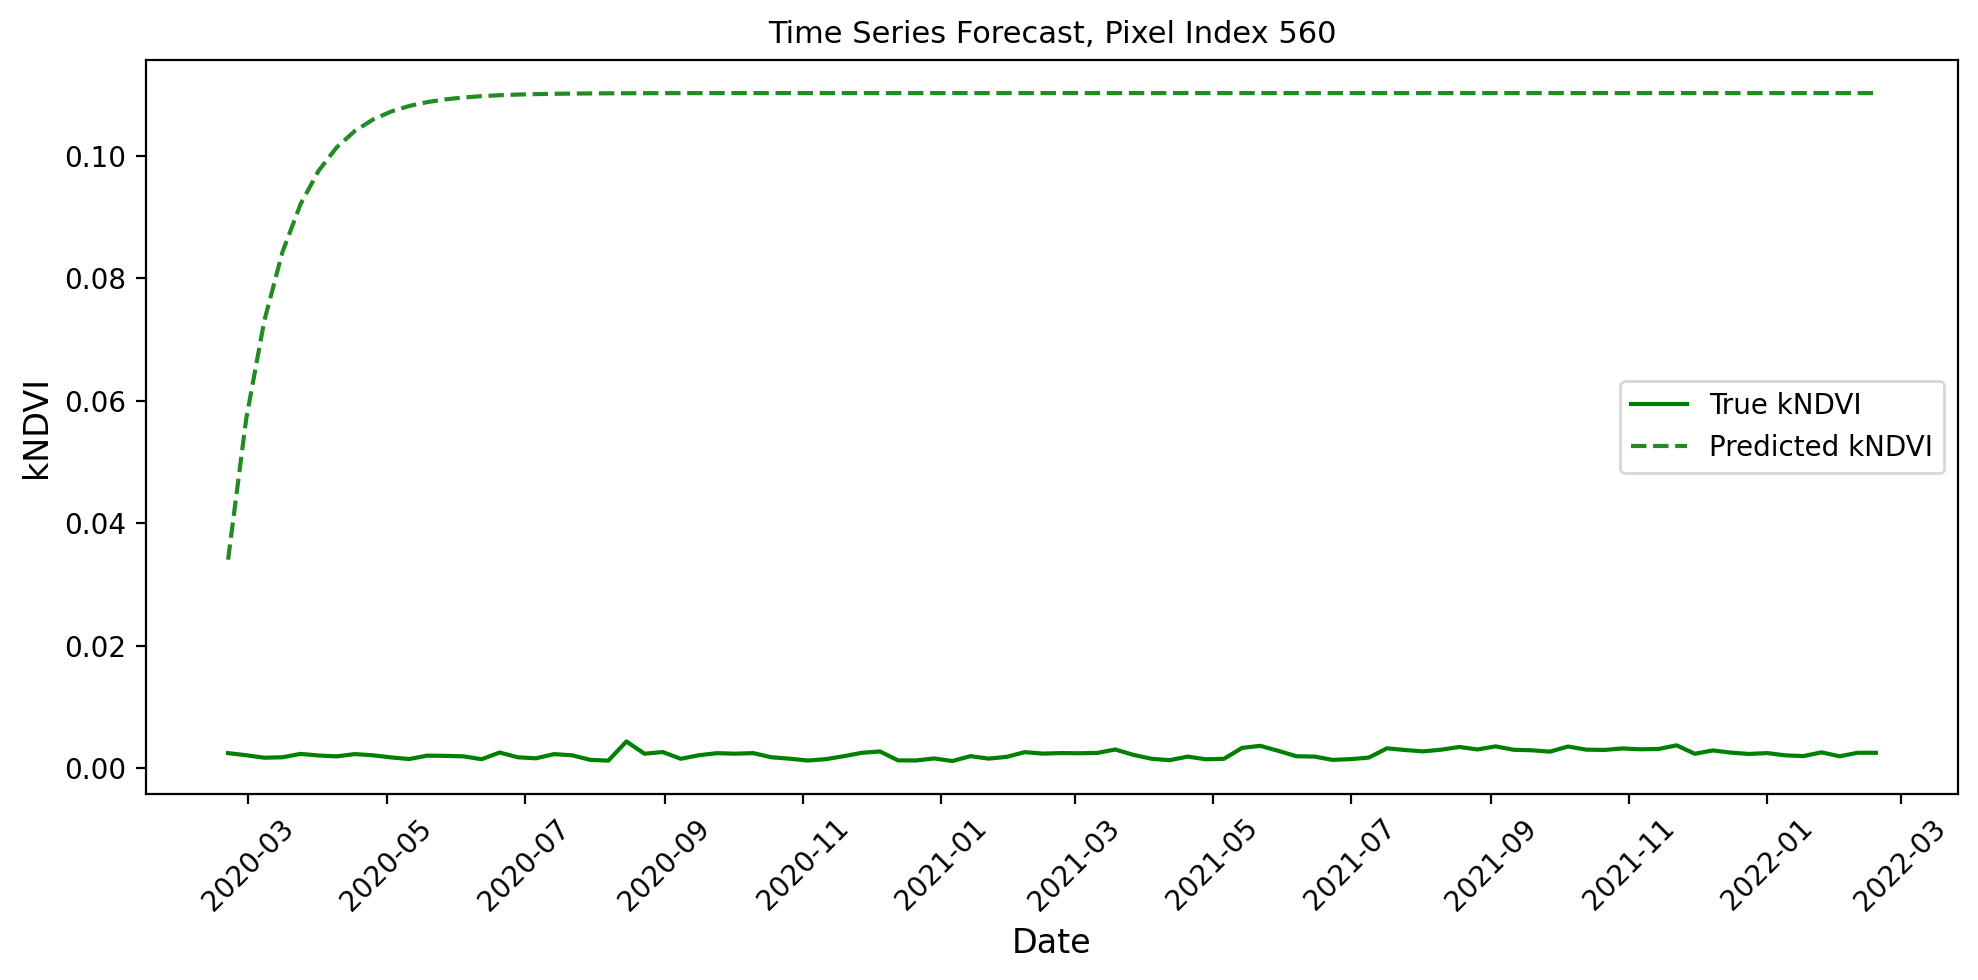

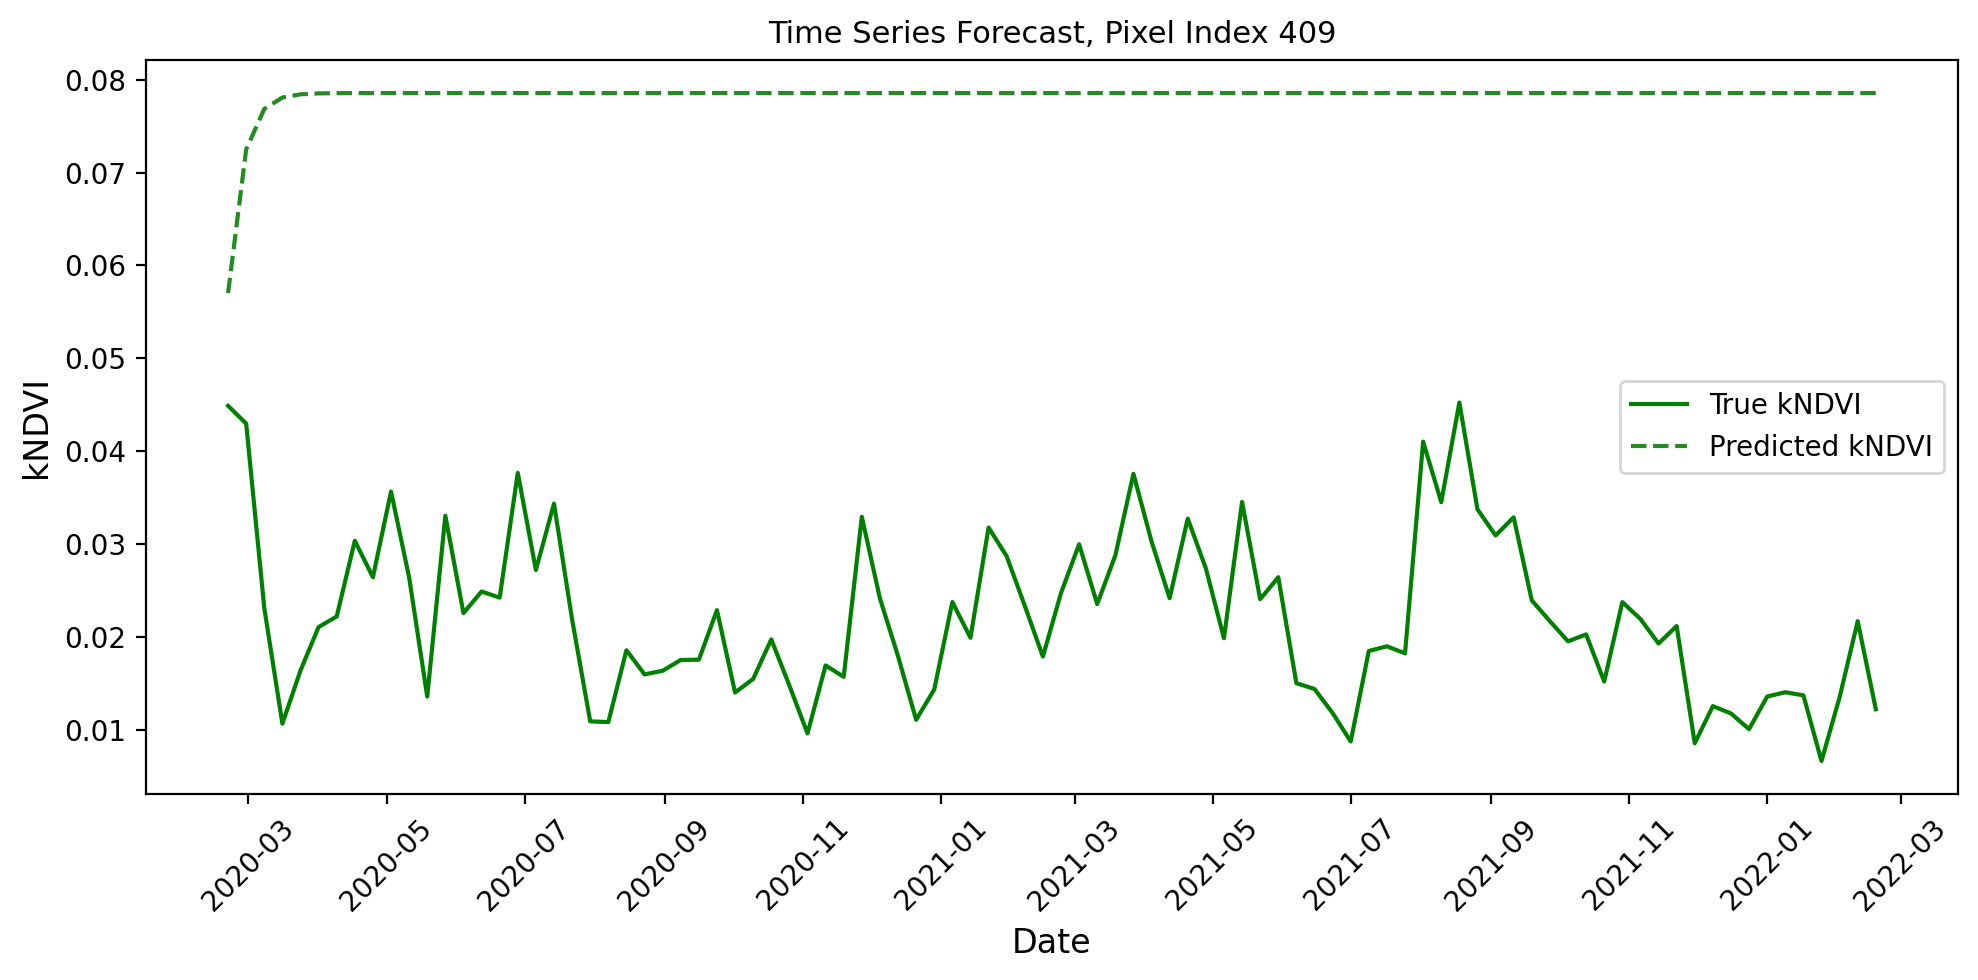

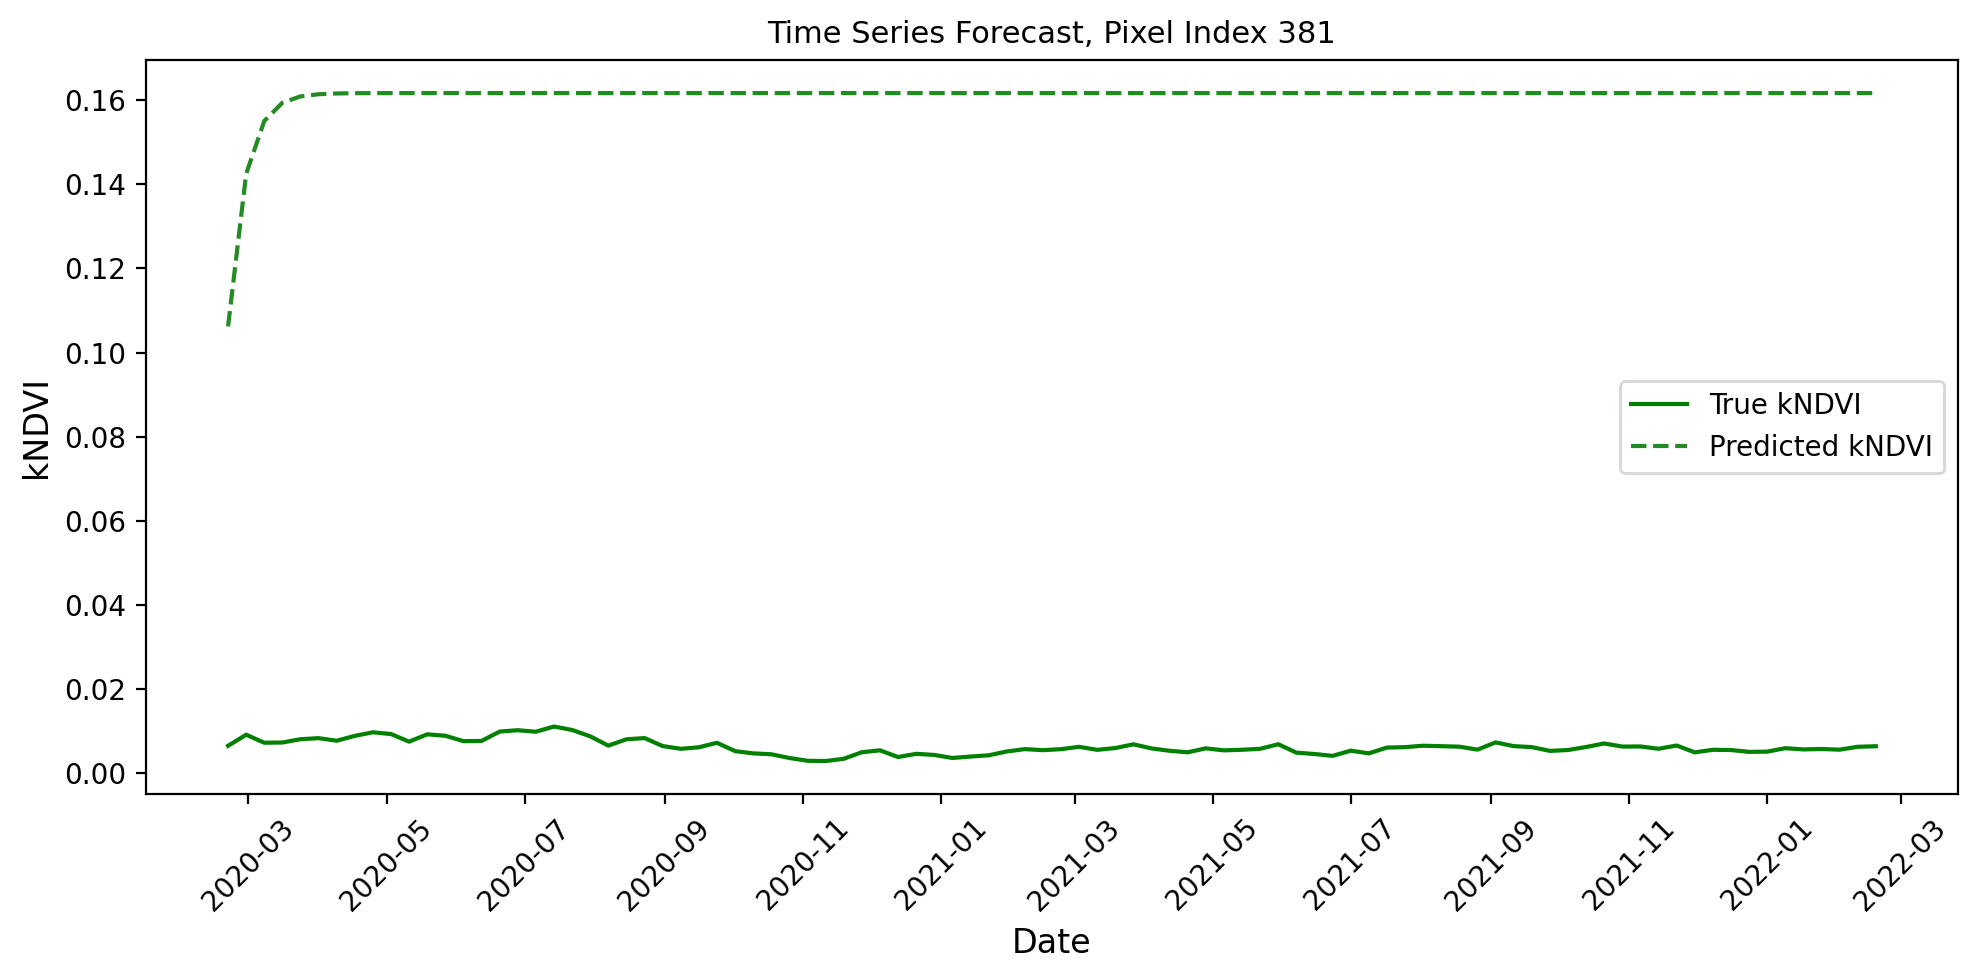

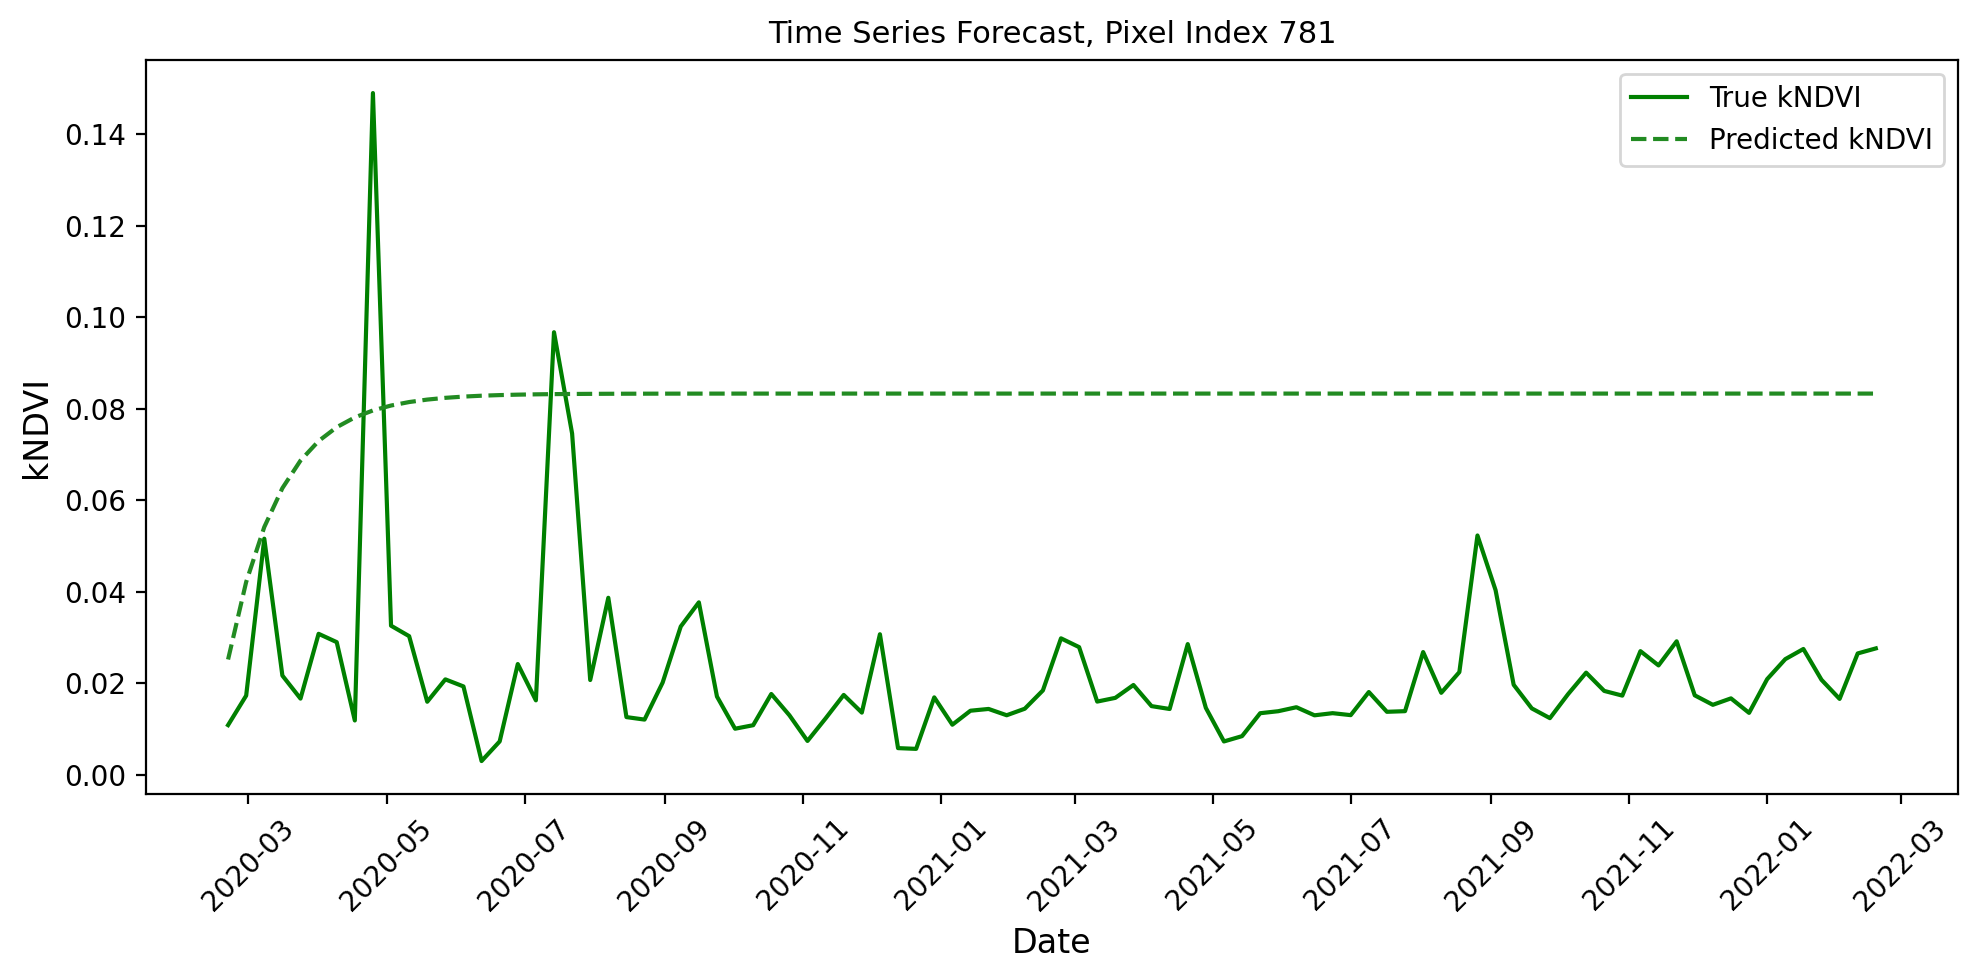

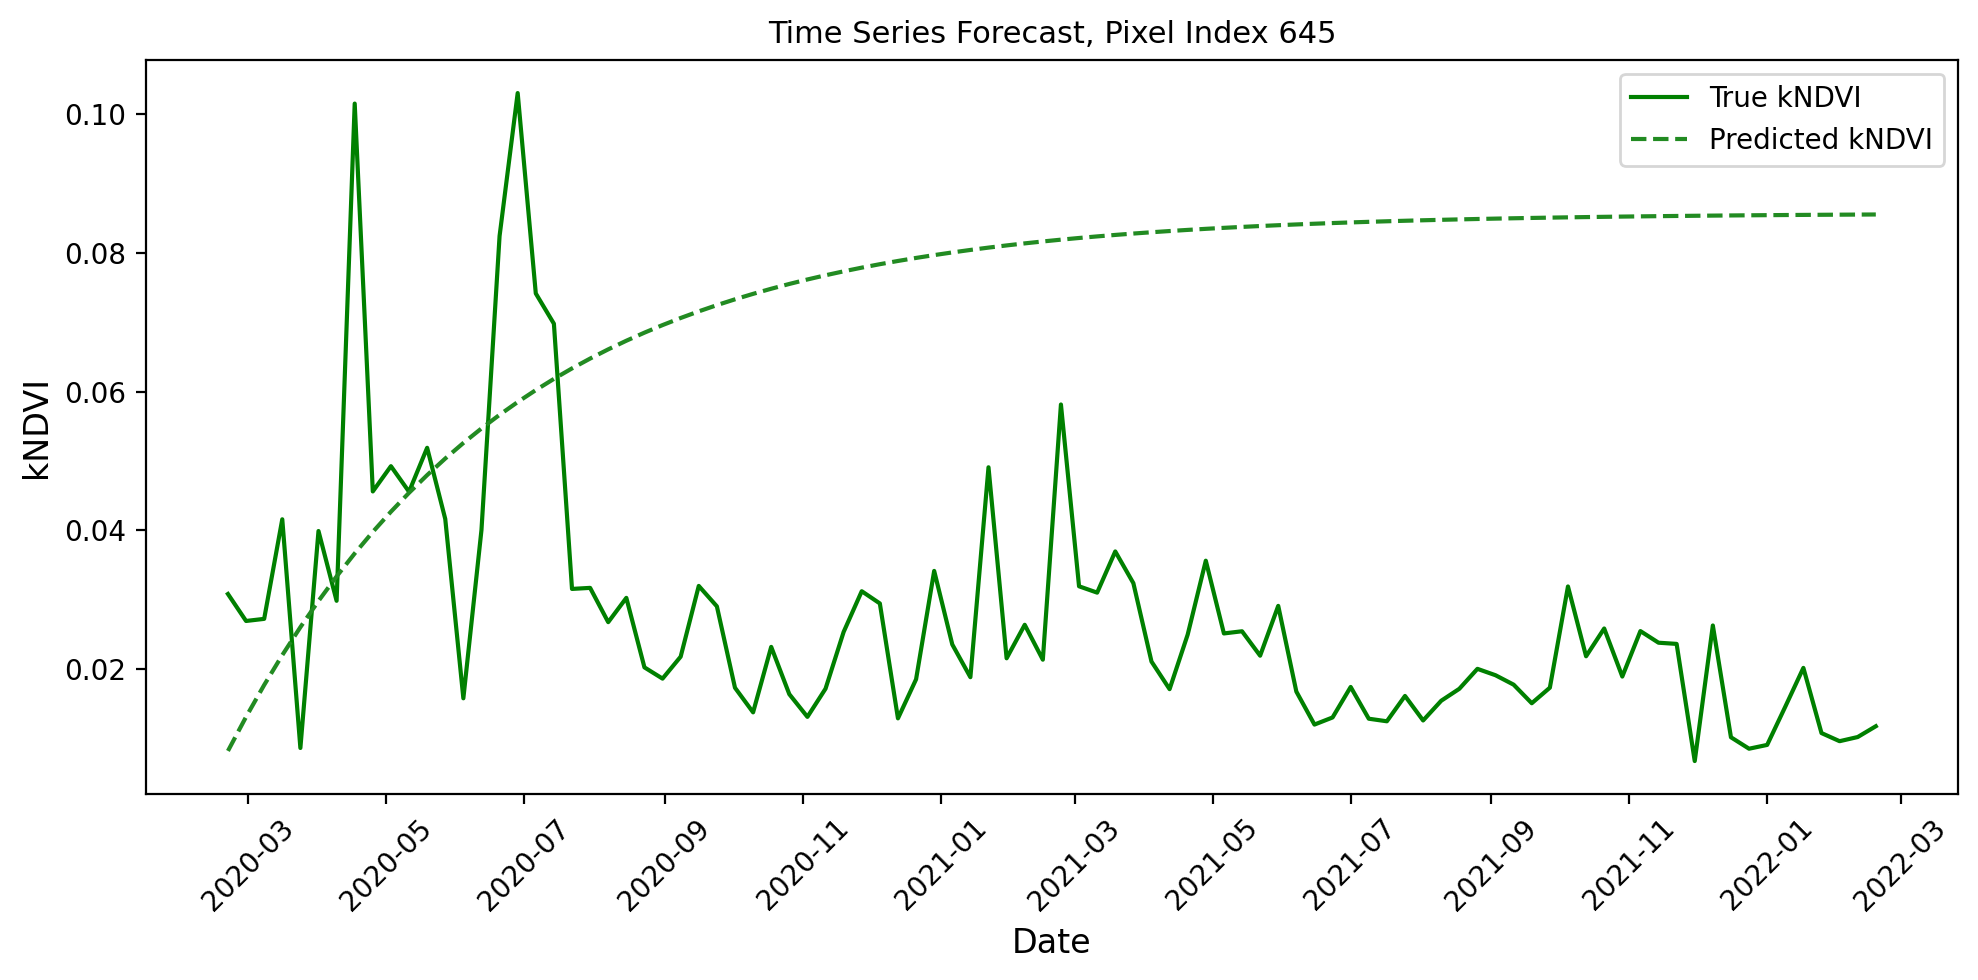

In [ ]:

# Assuming the date range is the last 92 time steps (test set)
date_range = pd.date_range("2020-02-21", periods=92, freq="8D")  # adjust `start` as needed

n_samples_to_plot = 5
random_indices = np.random.choice(forecast_matrix.shape[0], n_samples_to_plot, replace=False)

for i in random_indices:
    y_true = test_kndvi[-92:, i]
    y_pred = forecast_matrix[i]

    mse_val, rmse_val, mape_val, mae_val = compute_metrics(y_true, y_pred)

    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(date_range, y_true, label="True kNDVI", color="green")
    plt.plot(date_range, y_pred, label="Predicted kNDVI", color="forestgreen", linestyle="--")

    plt.title(f"Time Series Forecast, Pixel Index {i}", fontsize=11)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("kNDVI", fontsize=12)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{path}/figures/pixel_{i}.png")
    plt.show()

